### InverseTimeDecay Learning Rate

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

train_size = 7400
batch_size = 128
epochs = 40
initial_learning_rate = 0.001
decay_rate = 0.1

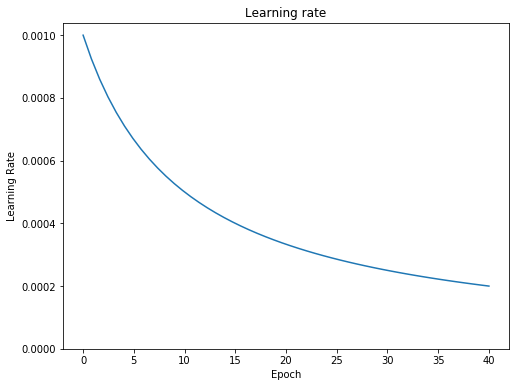

In [2]:
# By using InverseTimeDecay
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = train_size // batch_size,
    decay_rate = decay_rate,
    staircase = False
)

# Plot the function
step_per_epoch = train_size // batch_size
step = np.linspace(0,step_per_epoch*epochs)

lr = lr_schedule(step)

plt.figure(figsize = (8,6))
plt.plot(step/step_per_epoch, lr)
plt.ylim([0,max(plt.ylim())])
plt.title('Learning rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate');

# opt = tf.keras.optimizers.SGD(lr_schedule)

In [3]:
print (lr.numpy())

[0.001      0.00092453 0.00085965 0.00080328 0.00075385 0.00071014
 0.00067123 0.00063636 0.00060494 0.00057647 0.00055056 0.00052688
 0.00050515 0.00048515 0.00046667 0.00044954 0.00043363 0.0004188
 0.00040496 0.000392   0.00037984 0.00036842 0.00035766 0.00034752
 0.00033793 0.00032886 0.00032026 0.0003121  0.00030435 0.00029697
 0.00028994 0.00028324 0.00027684 0.00027072 0.00026486 0.00025926
 0.00025389 0.00024873 0.00024378 0.00023902 0.00023445 0.00023005
 0.00022581 0.00022172 0.00021778 0.00021397 0.0002103  0.00020675
 0.00020332 0.0002    ]


### Data Augmentation

In [ ]:
def train_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    #Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

### Keras Functional API

In [ ]:
def build_model(output_size, input_shape=(224, 224, 3), final_activation="softmax"):

    base_model = ResNet50(
        input_shape=input_shape,
        weights="imagenet",
        include_top=False
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    output = Dense(output_size, activation=final_activation)(x)
    
    return Model(outputs=output, inputs=base_model.input)


model = build_model(output_size = 23)